In [1]:
import os 
import sys
import math

import pickle
import optuna
import logging
import numpy as np
import pandas as pd
import seaborn as sn
# from tqdm import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

np.random.seed(2022)
data_folder = '../data/'

# Load the dataset

- Choose from the following cells the input features of the dataset.
- convert categorical features to a suitable numerical representation (use one-hot encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the land cover or land use of the tile is changed or not. 

#### 8-neighbors 

In [2]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']


#### 4-neighbors 

In [3]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1']

#### Time-deactivation

In [4]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'nbr1_LU3', 'nbr1_LC3', 'nbr2_LU3', 'nbr2_LC3', 'nbr3_LU3', 'nbr3_LC3',
           'nbr4_LU3', 'nbr4_LC3', 'nbr5_LU3', 'nbr5_LC3', 'nbr6_LU3', 'nbr6_LC3', 'nbr7_LU3', 'nbr7_LC3',
           'nbr8_LU3', 'nbr8_LC3']

#### Space-deactivation

In [5]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1']

In [6]:
original_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1
RELI,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61
48621113,LU103,LC47,LU103,LC47,LU421,LC31,LU421,LC31
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU106,LC12
48621115,LU142,LC11,LU142,LC15,LU142,LC15,LU142,LC15


In [7]:
original_data.sort_index(axis=1, inplace=True)
original_data.columns

Index(['LC1', 'LC2', 'LC3', 'LC4', 'LU1', 'LU2', 'LU3', 'LU4'], dtype='object')

In [8]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 348474
The length of the data without the rows with nan value is: 348474


In [9]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.drop(['LC4', 'LU4'], axis=1, inplace=True)
data_features.head()

,LC1,LC2,LC3,LU1,LU2,LU3,changed
RELI,,,,,,,
48561099,LC41,LC41,LC41,LU301,LU301,LU301,0
48611112,LC61,LC61,LC61,LU402,LU402,LU402,0
48621113,LC31,LC31,LC47,LU421,LU421,LU103,0
48621114,LC12,LC12,LC12,LU106,LU106,LU106,0
48621115,LC15,LC15,LC15,LU142,LU142,LU142,1


In [10]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58737


In [11]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [12]:
[train, test] = split_set(data_features)

In [13]:
train_categorical = pd.get_dummies(train)
train_categorical.columns

Index(['changed', 'LC1_LC11', 'LC1_LC12', 'LC1_LC13', 'LC1_LC14', 'LC1_LC15',
       'LC1_LC16', 'LC1_LC17', 'LC1_LC21', 'LC1_LC31',
       ...
       'LU3_LU302', 'LU3_LU303', 'LU3_LU304', 'LU3_LU401', 'LU3_LU402',
       'LU3_LU403', 'LU3_LU421', 'LU3_LU422', 'LU3_LU423', 'LU3_LU424'],
      dtype='object', length=220)

In [14]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test)[train_categorical.columns]

In [15]:
train_label=train_categorical.changed
train_features = train_categorical.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.changed
test_features = test_categorical.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 278198
Length of the test dataset : 70276


# XGboost & Random Forest 

In [16]:
class Classsifers():
    
    def __init__(self, train_x, train_y, classifers, study_name, n_trials=20):
        '''
        init the finetuning of multiple classifiers
        @params:
        train_x: input training features
        train_y: ground-truth label of training set
        ...
        classifiers: name of classifier to optimize
        '''
        self.train_x = train_x
        self.train_y = train_y
        self._classsifers = classifers
        self.n_cpus = int(os.cpu_count() - 8)
        self.n_trials = n_trials
        self.study_name = study_name
        self.storage_name = "sqlite:///{}.db".format(study_name)
        self.acc_mean = 0
        self.study = optuna.create_study(study_name=self.study_name, direction='maximize', storage=self.storage_name, load_if_exists=True)
        try:
            # if os.path.exists('./{}.db'.format(study_name)):
            self.best_opt_metric = self.study.best_value
            self._best_params = self.study.best_params
        except ValueError:
            pass
            
        
    def objective(self, trial):
        # define the tuning object with fields and range of the hyper params
        classsifer = trial.suggest_categorical('classsifer', self._classsifers)

        if classsifer == 'RandomForest':
            # cf. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

            params = dict(
                criterion = trial.suggest_categorical('criterion', ["gini", "entropy", "log_loss"]),
                bootstrap = True,
                max_depth = trial.suggest_int('max_depth', 10, 1000),
                oob_score = True,
                max_features = trial.suggest_categorical('max_features', [None, 'sqrt','log2']),
                min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 8000, step=500)),
                class_weight = 'balanced_subsample',
                n_jobs=self.n_cpus
            )
            model = RandomForestClassifier(**params)

        elif classsifer == 'XGBoost':
            # cf. https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=n_estimators#module-xgboost.sklearn
            params = dict(
                booster = trial.suggest_categorical('booster', ["gbtree"]),
                learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3),
                gamma = trial.suggest_float('gamma', 0, 1),
                max_depth = trial.suggest_int('max_depth', 3, 15),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 4000, step=500)),
                min_child_weight = trial.suggest_int('min_child_weight', 1, 12),
                gpu_id = 0,
                tree_method = 'gpu_hist'
            )
            model = XGBClassifier(**params, n_jobs=self.n_cpus, importance_type='gain')

        else:
            raise Exception('Invalid regressor. Only the following choices are valid: "RandomForest", "XGBoost".')

        score = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        acc_mean = score.mean()

        return acc_mean
        
    def optimize(self, cv=5):
        # hyper params tuning with Optuna
        # detailed explanation of Optuna: https://optuna.org/

        self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=max(self.n_cpus, 1))

        # /!\ we need to make sure that type(n_estimators) == 'int'
        best_params = self.study.best_params.copy()
        best_params['n_estimators'] = int(best_params['n_estimators'])
        print("Best parameters:", best_params)
        print("Best score (mean balanced_accuracy after 5-fold Cross Validation):", self.study.best_value)
        self._best_params = best_params
        self.best_opt_metric = self.study.best_value

        
    def compute_confusion_matrix(self): 
    
        TP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==1))
        TN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==0))
        FP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==0))
        FN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==1))

        self._confusion_matrix = np.asarray([[TP, FP],
                                        [FN, TN]])
        return self._confusion_matrix


    def plot_confusion_matrix(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix
        label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                            ['FN {}'.format(FN), 'TN {}'.format(TN)]])

        df_cm = pd.DataFrame(self._confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

        sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion matrix')



    def compute_score(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix.astype(float)

        accuracy =  (TP+TN)/np.sum(self._confusion_matrix)

        precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
        precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan

        recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
        recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

        F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
        F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

        print("The accuracy of model is {:1.3f}".format(accuracy))
        print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_positive, recall_positive, F1_score_positive))
        print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_negative, recall_negative, F1_score_negative))

        return {
            'accuracy': accuracy,
            'precision_positive': precision_positive,
            'recall_positive': recall_positive,
            'F1_score_positive': F1_score_positive,
            'precision_negative': precision_negative,
            'recall_negative': recall_negative,
            'F1_score_negative': F1_score_negative
        }

        
        
    def best_model(self):
        # init the best model with optimized params
        params_dict = self._best_params.copy()
        cls_best = params_dict.pop('classsifer')
        if cls_best == 'RandomForest':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = RandomForestClassifier(**params_dict, n_jobs=self.n_cpus)
        elif cls_best == 'XGBoost':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = XGBClassifier(**params_dict, n_jobs=self.n_cpus, gpu_id = 0, tree_method = 'gpu_hist',
                                       importance_type='gain')
        elif cls_best == 'LightGBM':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = LGBMClassifier(**params_dict, n_jobs=self.n_cpus, importance_type='gain')
            # best_model = LGBMClassifier(**params_dict, n_jobs=self.n_cpus, importance_type='gain', device = 'gpu')
            # gpu_platform_id = 0, gpu_device_id = 0
        print(params_dict)
                
        best_model.fit(self.train_x, self.train_y)
        score = cross_val_score(best_model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        self.score = score.mean()
        self.best_model = best_model
        
        print('Best model initialized with balanced accuracy: {:.3f} \n'.format(self.score))

    
    def _evaluate(self, test_x, test_y):
        # evaluate the performance of given test data
        self._true_label_test = test_y
        from sklearn.metrics import balanced_accuracy_score
        self._predict_label_test = self.best_model.predict(test_x)
        acc_balanced = balanced_accuracy_score(self._true_label_test, self._predict_label_test)
        
    
    def save_model(self, path):
        # Save to file in the current working directory
        with open(path, 'wb') as file:
            pickle.dump(self.best_model, file)
        
    
    def load_model(self, path):
        # Load from file
        with open(path, 'rb') as file:
            self.best_model = pickle.load(file)
        

## Train and test the models

In [17]:
# Use the argument classifers=['XGBoost'] or classifers=['RandomForest'] to choose the model to train
test_cls = Classsifers(train_x=train_features, train_y=train_label, classifers=['XGBoost'], study_name='XGBoost-space-deactivate', n_trials=200)

[I 2022-10-05 09:38:26,546] A new study created in RDB with name: XGBoost-space-deactivate


In [18]:
test_cls.optimize()

[I 2022-10-05 09:43:59,537] Trial 6 finished with value: 0.5734105717122674 and parameters: {'classsifer': 'XGBoost', 'booster': 'gbtree', 'learning_rate': 0.2605148465142581, 'gamma': 0.6649964830922073, 'max_depth': 7, 'n_estimators': 1000.0, 'min_child_weight': 3}. Best is trial 6 with value: 0.5734105717122674.
[I 2022-10-05 09:45:36,533] Trial 7 finished with value: 0.5728494633589061 and parameters: {'classsifer': 'XGBoost', 'booster': 'gbtree', 'learning_rate': 0.17489836852275067, 'gamma': 0.8660717037466975, 'max_depth': 13, 'n_estimators': 1000.0, 'min_child_weight': 12}. Best is trial 6 with value: 0.5734105717122674.
[I 2022-10-05 09:46:50,758] Trial 12 finished with value: 0.5736537766068368 and parameters: {'classsifer': 'XGBoost', 'booster': 'gbtree', 'learning_rate': 0.2618069163962301, 'gamma': 0.24949930273794485, 'max_depth': 4, 'n_estimators': 2500.0, 'min_child_weight': 4}. Best is trial 12 with value: 0.5736537766068368.
[I 2022-10-05 09:49:15,785] Trial 8 finishe

Best parameters: {'booster': 'gbtree', 'classsifer': 'XGBoost', 'gamma': 0.0030372391921170755, 'learning_rate': 0.27910423942121965, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 2000}
Best score (mean balanced_accuracy after 5-fold Cross Validation): 0.578546311632883


In [19]:
test_cls.best_opt_metric

0.578546311632883

In [20]:
test_cls._best_params

{'booster': 'gbtree',
 'classsifer': 'XGBoost',
 'gamma': 0.0030372391921170755,
 'learning_rate': 0.27910423942121965,
 'max_depth': 9,
 'min_child_weight': 9,
 'n_estimators': 2000}

In [21]:
test_cls.best_model()

{'booster': 'gbtree', 'gamma': 0.0030372391921170755, 'learning_rate': 0.27910423942121965, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 2000}
Best model initialized with balanced accuracy: 0.579 



In [65]:
test_cls.load_model('./xgboost_615.pkl')

In [22]:
test_cls.save_model('./XGBoost-space-deactivate_579.pkl')

In [23]:
test_cls._evaluate(test_features, test_label)

In [24]:
test_cls.compute_confusion_matrix()

array([[ 2202,   985],
       [ 9659, 57430]])

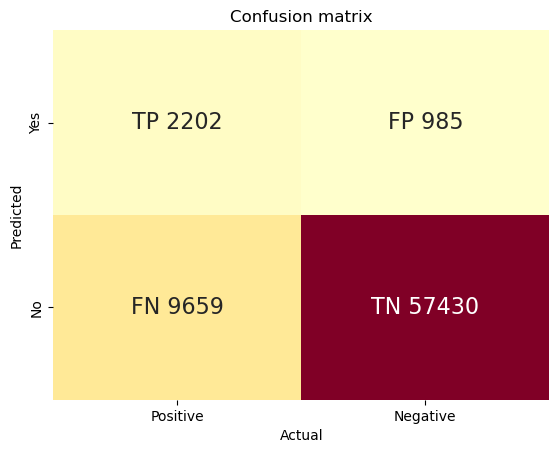

In [25]:
test_cls.plot_confusion_matrix()

In [26]:
test_cls.compute_score()

The accuracy of model is 0.849
For the positive case, the precision is 0.691, the recall is 0.186 and the F1 score is 0.293
For the negative case, the precision is 0.856, the recall is 0.983 and the F1 score is 0.915


{'accuracy': 0.8485400421196425,
 'precision_positive': 0.6909319108879824,
 'recall_positive': 0.18565045105808953,
 'F1_score_positive': 0.2926634768740032,
 'precision_negative': 0.8560270685209199,
 'recall_negative': 0.9831378926645553,
 'F1_score_negative': 0.9151899541050484}

# Feature importance analysis

In [27]:
feature_imp = pd.DataFrame([[f, imp] for f, imp in zip(train_features.columns, test_cls.best_model.feature_importances_)], columns=['feature', 'feature_importance'])
feature_imp.sort_values('feature_importance', inplace=True, ascending=False)
feature_imp = feature_imp.query('feature_importance > 0')
feature_imp.head()

,feature,feature_importance
207,LU3_LU243,0.156651
218,LU3_LU424,0.114366
13,LC1_LC41,0.092136
210,LU3_LU303,0.042752
65,LC3_LC34,0.042572


In [28]:
feature_imp.head(10)

,feature,feature_importance
207,LU3_LU243,0.156651
218,LU3_LU424,0.114366
13,LC1_LC41,0.092136
210,LU3_LU303,0.042752
65,LC3_LC34,0.042572
74,LC3_LC51,0.034347
205,LU3_LU241,0.032125
47,LC2_LC51,0.029775
208,LU3_LU301,0.028439
71,LC3_LC45,0.025312


## Compare feature importance from self and neighbors 

In [29]:
super_f = []
time_space = []
for ind, f in feature_imp.iterrows():
    super_f.append('_'.join(f['feature'].split('_')[:-1]))
    if f['feature'].startswith('nbr'):
        time_space.append('neighour')
    else:
        time_space.append('self')

feature_imp['super_feat'] = super_f
feature_imp['time_space'] = time_space

In [30]:
df_ts = feature_imp.groupby(['time_space']).sum()
df_ts.index.name = 'super_feat'
df_ts

,feature_importance
super_feat,
self,1.0


## Compare feature importance w.r.t neighboring tiles and surveys

In [31]:
df_feat = feature_imp.groupby(['super_feat']).sum()
df_feat = pd.concat([df_feat,df_ts])
df_feat.sort_values('feature_importance', inplace=True, ascending=False)

In [32]:
df_feat.head()

,feature_importance
super_feat,
self,1.000000
LU3,0.511470
LC3,0.220944
LC1,0.136297
LC2,0.072095


Text(0.5, 0, 'Space-deactivation Feature Importance')

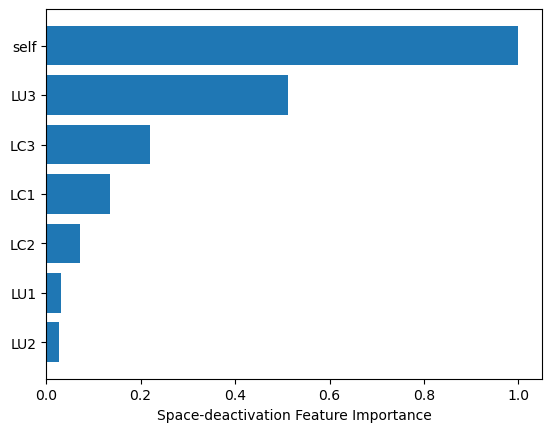

In [33]:
plt.barh(df_feat.index.values[::-1][-15:], df_feat.feature_importance.values[::-1][-15:])
# plt.xlabel("Random Forest Feature Importance")
plt.xlabel("Space-deactivation Feature Importance")

## Compare feature importance w.r.t neighboring tiles, surveys and classes

Text(0.5, 0, 'XGBoost Feature Importance')

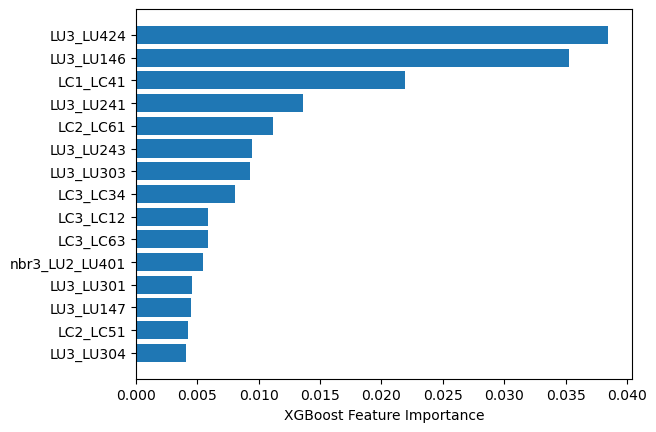

In [79]:
feature_imp.sort_values('feature_importance', inplace=True, ascending=False)
plt.barh(feature_imp.feature.values[::-1][-15:], feature_imp.feature_importance.values[::-1][-15:])
# plt.xlabel("Random Forest Feature Importance")
plt.xlabel("XGBoost Feature Importance")